In [92]:
import torch
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from collections import Counter

In [93]:
ft_epochs = torch.arange(4, 100, 5)
abs_distances_pre: torch.Tensor = torch.load('./trained_models/distances_solid_absolute_pre.pt', map_location='cpu')
abs_distances_ft: torch.Tensor = [
    torch.load(f'./trained_models/distances_solid_absolute_{i}.pt', map_location='cpu')
    for i in ft_epochs
]
abs_distances_pre.size()
ft_epochs

tensor([ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89,
        94, 99])

In [94]:
l2s = range(10)
borders = range(10)
centers = [0, 1, 2, 4, 5, 6, 7, 8, 9]
l2_files = [
    torch.load(f'./trained_models/distances_l2_border_stl10_perturb_0.{i}.pt')
    for i in l2s
]
border_files = [
    torch.load(f'./trained_models/distances_border_stl10_perturb_0.{i}.pt')
    for i in borders
]
center_files = [
    torch.load(f'./trained_models/distances_center_stl10_perturb_0.{i}.pt')
    for i in centers
]

In [95]:
deltas = [0.1, 0.05, 0.005]
l2_delta_mems = {delta : [torch.sum(l2_files[i] / 30 < delta) for i in range(len(l2_files))] for delta in deltas}
border_delta_mems = {delta : [torch.sum(border_files[i] < delta) for i in range(len(border_files))] for delta in deltas}
center_delta_mems = {delta : [torch.sum(center_files[i] < delta) for i in range(len(center_files))] for delta in deltas}

In [96]:
for delta in deltas:
    print(f"Delta: {delta}; Border: {border_delta_mems[delta][0]}; Center: {center_delta_mems[delta][0]}")
    print(f"L2: {l2_delta_mems[delta][0]}")

Delta: 0.1; Border: 1879; Center: 1927
L2: 10000
Delta: 0.05; Border: 977; Center: 1011
L2: 1095
Delta: 0.005; Border: 81; Center: 107
L2: 0


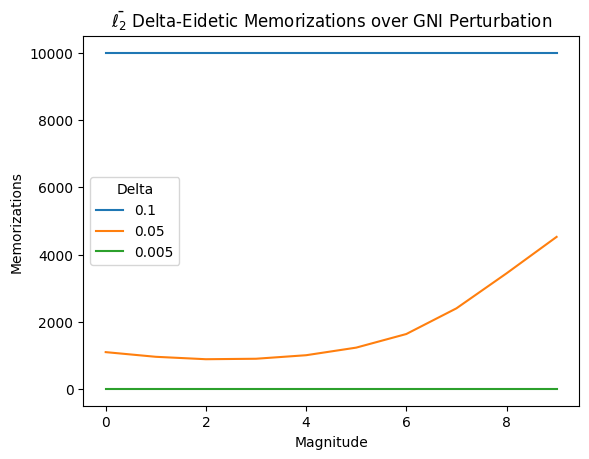

In [97]:
for i, delta in enumerate(deltas):
    plt.plot(l2s, l2_delta_mems[delta], label=delta)
plt.legend(title="Delta")
plt.title("$\\bar{\ell_2}$ Delta-Eidetic Memorizations over GNI Perturbation")
plt.xlabel("Magnitude")
plt.ylabel("Memorizations")
plt.show()

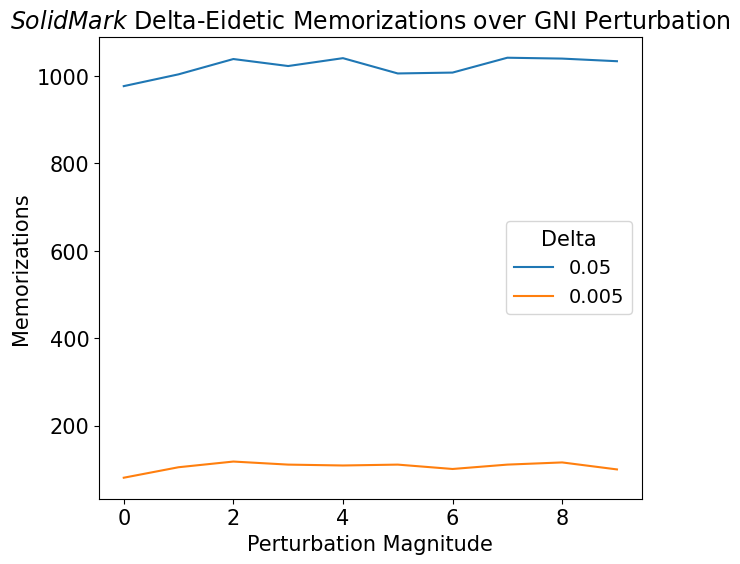

In [98]:
deltas = [0.05, 0.005]
plt.figure(figsize=(7, 6))
for i, delta in enumerate(deltas):
    plt.plot(borders, border_delta_mems[delta], label=delta)
leg=plt.legend(title="Delta",fontsize=14)
plt.setp(leg.get_title(),fontsize='15')
plt.title("$SolidMark$ Delta-Eidetic Memorizations over GNI Perturbation", fontsize=17)
plt.xlabel("Perturbation Magnitude", fontsize=15)
plt.ylabel("Memorizations", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

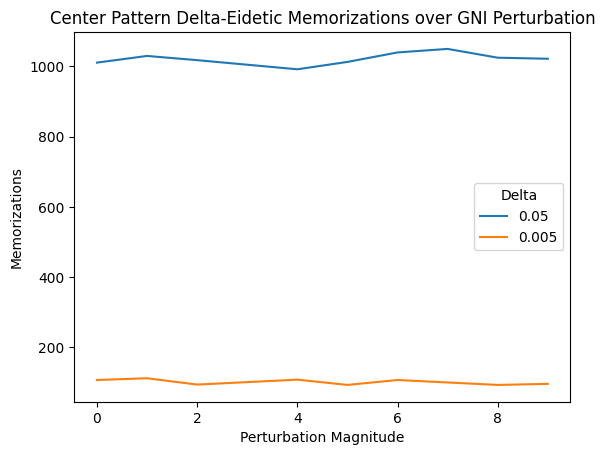

In [99]:
for i, delta in enumerate(deltas):
    plt.plot(centers, center_delta_mems[delta], label=delta)
plt.legend(title="Delta")
plt.title("Center Pattern Delta-Eidetic Memorizations over GNI Perturbation")
plt.xlabel("Perturbation Magnitude")
plt.ylabel("Memorizations")
plt.show()

In [100]:
distance_buckets = [0.01, 0.001]
delta_mems = {delta : torch.sum(abs_distances_pre < delta) for delta in distance_buckets}
delta_mems

{0.01: tensor(163), 0.001: tensor(24)}

In [101]:
ft_epochs = torch.cat((torch.tensor([0]), ft_epochs))
abs_distances_ft = [abs_distances_pre] + abs_distances_ft
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_{epoch}_0.001.pt', map_location='cpu') for epoch in ft_epochs])

In [102]:
buckets_per_ft = [
    [sum(distance < bucket) for distance in abs_distances_ft]
    for bucket in distance_buckets
]

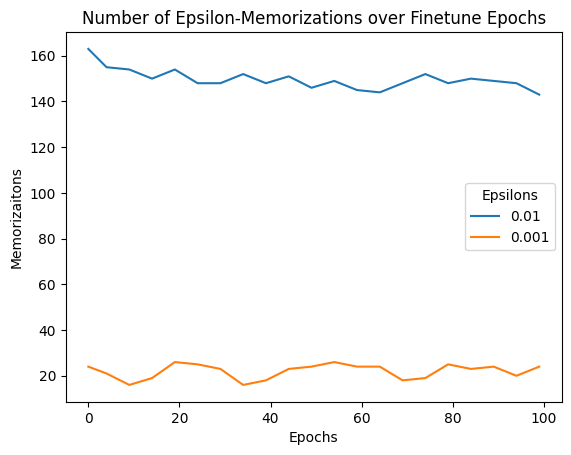

In [103]:
for i, bucket in enumerate(distance_buckets):
    plt.plot(ft_epochs, buckets_per_ft[i], label=bucket)
plt.legend(title="Epsilons")
plt.title("Number of Epsilon-Memorizations over Finetune Epochs")
plt.xlabel("Epochs")
plt.ylabel("Memorizaitons")
plt.show()

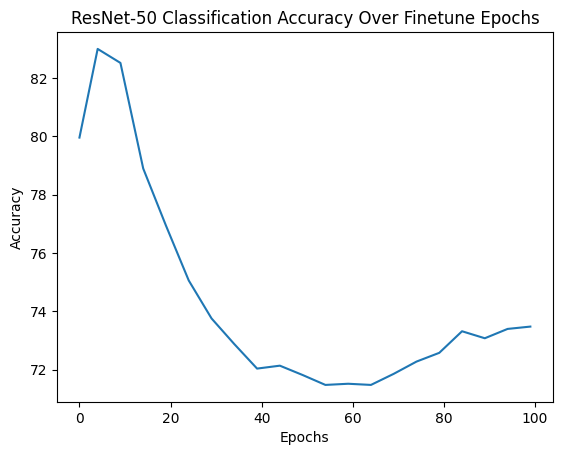

In [104]:
plt.plot(ft_epochs, accuracies)
plt.title("ResNet-50 Classification Accuracy Over Finetune Epochs")
plt.ylabel('Accuracy')
plt.xlabel("Epochs")
plt.show() 

In [105]:
ft_epochs = torch.arange(2, 22, 2)
mnist_epoch: int = 49 # MNIST Epoch - 1, so zero would be one epoch of FT
baseline_distances: torch.Tensor = abs_distances_pre
baseline_accuracy = accuracies[0]
abs_distances_ft: list[torch.Tensor] = [
    torch.load(f'./trained_models/distances_solid_absolute_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu')
    for epoch in ft_epochs
]
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu') for epoch in ft_epochs])
abs_distances_pre.size()
ft_epochs

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [106]:
buckets_per_ft = [
    [sum(distance < bucket) for distance in abs_distances_ft]
    for bucket in distance_buckets
]
baseline_buckets = [sum(baseline_distances < bucket) for bucket in distance_buckets]

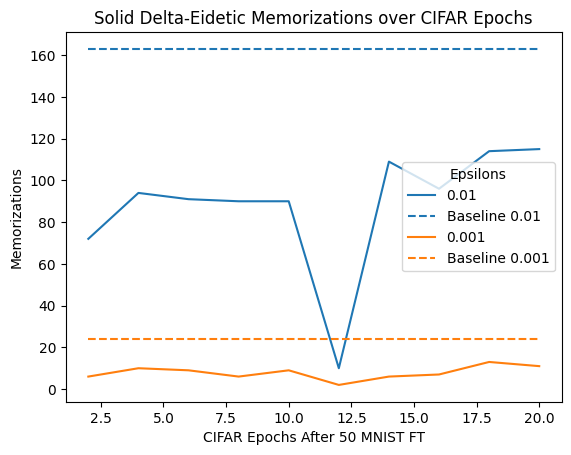

In [107]:
ax: Axes = plt.gca()
for i, bucket in enumerate(distance_buckets):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ft_epochs, buckets_per_ft[i], label=bucket, color=color)
    plt.plot(ft_epochs, [baseline_buckets[i] for _ in ft_epochs], '--', label=f"Baseline {bucket}", color=color)
plt.legend(title="Epsilons")
plt.title("Solid Delta-Eidetic Memorizations over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Memorizations")
plt.show()

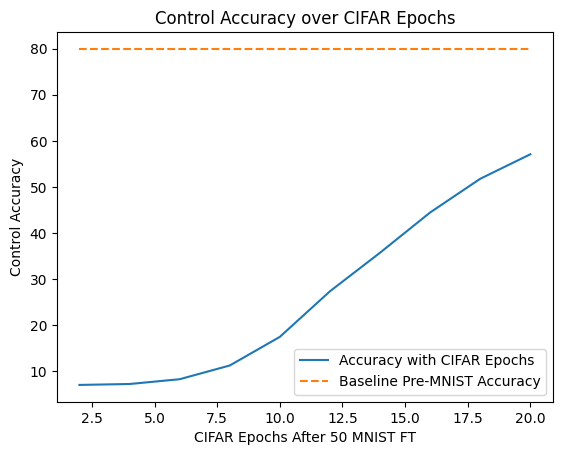

In [108]:
plt.plot(ft_epochs, accuracies, label="Accuracy with CIFAR Epochs")
plt.plot(ft_epochs, [baseline_accuracy for _ in ft_epochs], '--', label="Baseline Pre-MNIST Accuracy")
plt.title("Control Accuracy over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Control Accuracy")
plt.legend()
plt.show()

In [109]:
mnist_epochs = torch.arange(0, 50)
mnist_accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_epoch_{epoch}.pt', map_location='cpu') for epoch in mnist_epochs])

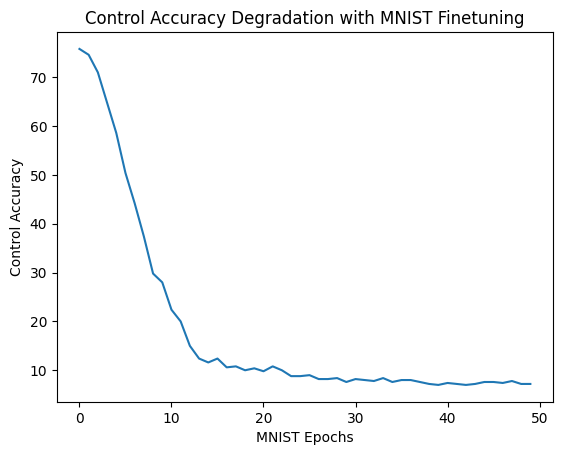

In [110]:
plt.plot(mnist_epochs, mnist_accuracies)
plt.xlabel("MNIST Epochs")
plt.ylabel("Control Accuracy")
plt.title("Control Accuracy Degradation with MNIST Finetuning")
plt.show()

In [111]:
gaussian_perturbs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
gaussian_distances: list[torch.Tensor] = [baseline_distances] + [
    torch.load(f'./trained_models/distances_solid_absolute_perturb_{i}.pt', map_location='cpu')
    for i in gaussian_perturbs
]
gaussian_perturbs = [0] + gaussian_perturbs
buckets_per_perturb = [
    [sum(distance < bucket) for distance in gaussian_distances]
    for bucket in distance_buckets
]

In [112]:
print(buckets_per_perturb[0])
print(buckets_per_perturb[1])

[tensor(163), tensor(162), tensor(156), tensor(149), tensor(134), tensor(119), tensor(87), tensor(70)]
[tensor(24), tensor(16), tensor(20), tensor(20), tensor(16), tensor(17), tensor(9), tensor(8)]


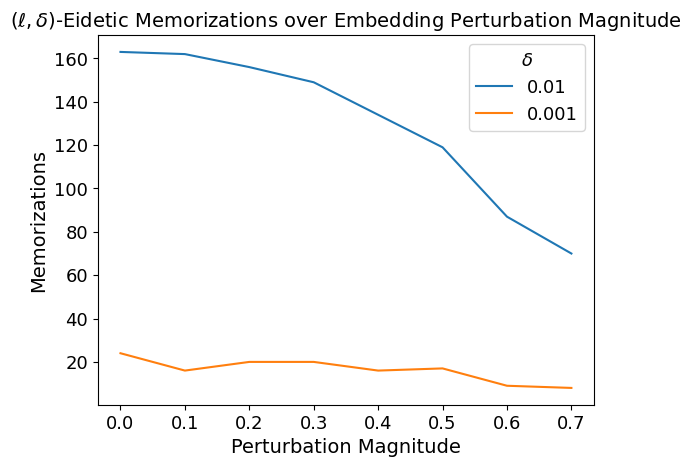

In [113]:
for i, bucket in enumerate(distance_buckets):
    plt.plot(gaussian_perturbs, buckets_per_perturb[i], label=bucket)
leg = plt.legend(title="$\delta$", fontsize=13)
plt.setp(leg.get_title(),fontsize=13)
plt.title("$(\ell, \delta)$-Eidetic Memorizations over Embedding Perturbation Magnitude", fontsize=14)
plt.xlabel("Perturbation Magnitude", fontsize=14)
plt.ylabel("Memorizations", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [114]:
def plot_technique(perturbs: torch.Tensor, name: str, buckets: list[int]):
    distances: list[torch.Tensor] = [
    torch.load(f'./trained_models/distances_sd_{name}_{i}.pt', map_location='cpu')
    for i in perturbs
    ]
    if name == "gaussian":
        name = "Gaussian"
    elif name == "RWA":
        name = "RT"
    buckets_per_perturb = [
        [sum(distance < bucket) for distance in distances]
        for bucket in buckets
    ]
    for perturb in buckets_per_perturb:
        print(perturb)
    for i, bucket in enumerate(distance_buckets):
        plt.plot(perturbs, buckets_per_perturb[i], label=bucket)
        plt.legend(title="Deltas")
        plt.title(f"Delta-Eidetic Memorizations over {name} Mitigation Strength")
        plt.xlabel("Mitigation Strength")
        plt.ylabel("Memorizations")
    plt.show()

In [115]:
distance_buckets = [0.1, 0.05, 0.005]

[tensor(781), tensor(804), tensor(700), tensor(684), tensor(638), tensor(628), tensor(589), tensor(621), tensor(553), tensor(581)]
[tensor(280), tensor(318), tensor(273), tensor(246), tensor(253), tensor(258), tensor(251), tensor(250), tensor(204), tensor(224)]
[tensor(25), tensor(25), tensor(29), tensor(24), tensor(15), tensor(20), tensor(33), tensor(22), tensor(17), tensor(20)]


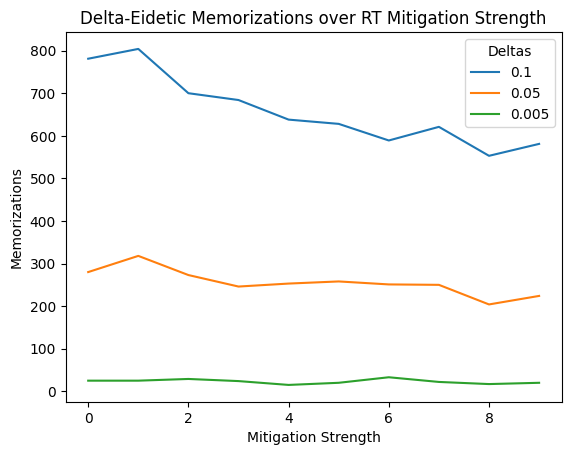

In [116]:
plot_technique(torch.arange(10), "RWA", distance_buckets)

[tensor(803), tensor(807), tensor(726), tensor(665), tensor(668), tensor(627), tensor(634), tensor(598), tensor(579), tensor(605)]
[tensor(311), tensor(267), tensor(274), tensor(226), tensor(258), tensor(258), tensor(245), tensor(218), tensor(241), tensor(226)]
[tensor(27), tensor(24), tensor(22), tensor(18), tensor(24), tensor(19), tensor(18), tensor(18), tensor(24), tensor(15)]


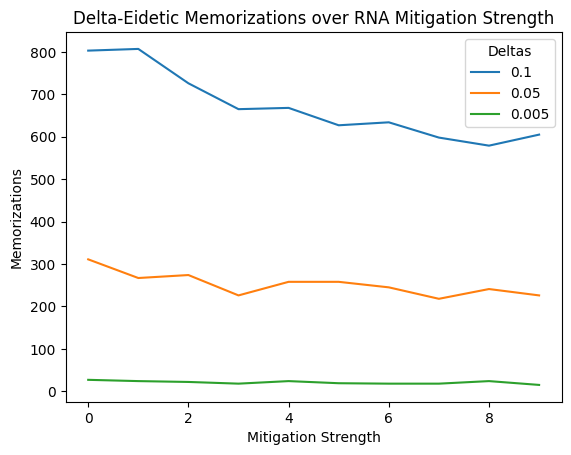

In [117]:
plot_technique(torch.arange(10), "RNA", distance_buckets)

[tensor(817), tensor(787), tensor(755), tensor(758), tensor(756), tensor(706), tensor(720), tensor(692), tensor(676), tensor(708)]
[tensor(293), tensor(281), tensor(288), tensor(295), tensor(266), tensor(254), tensor(265), tensor(265), tensor(267), tensor(272)]
[tensor(22), tensor(23), tensor(19), tensor(29), tensor(20), tensor(18), tensor(17), tensor(33), tensor(31), tensor(20)]


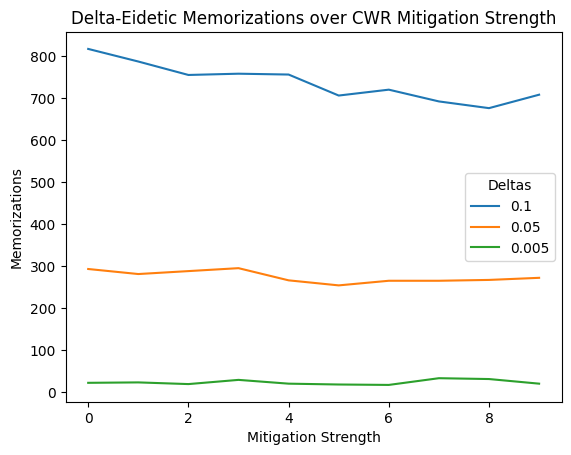

In [118]:
plot_technique(torch.arange(10), "CWR", distance_buckets)

[tensor(824), tensor(817), tensor(836), tensor(852), tensor(856), tensor(790), tensor(832), tensor(816), tensor(826), tensor(810)]
[tensor(312), tensor(302), tensor(297), tensor(316), tensor(319), tensor(286), tensor(309), tensor(311), tensor(287), tensor(318)]
[tensor(33), tensor(32), tensor(28), tensor(27), tensor(34), tensor(27), tensor(26), tensor(24), tensor(23), tensor(18)]


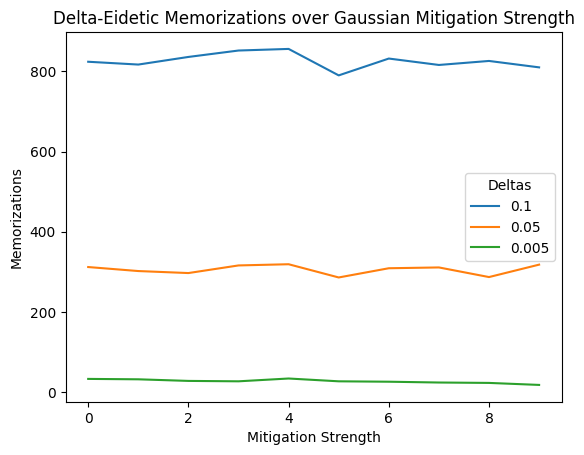

In [119]:
plot_technique(torch.arange(10), "gaussian", distance_buckets)

In [170]:
# pretrained_ckpts = list(range(1, 10)) + list(range(12, 20)) + list(range(21, 26)) + list(range(29, 40))
# pretrained_ckpts = list(range(1, 41)) + list(range(42, 57)) + list(range(58, 69)) + list(range(73, 91)) + list(range(92, 100))
pretrained_ckpts = list(range(1, 167)) + list(range(168, 185))
ckpts = [ckpt * 2500 for ckpt in pretrained_ckpts]
ckpt_files = [torch.load(f'./trained_models/distances_sd_pretrain_ckpt_{ckpt}.pt', map_location='cpu') for ckpt in ckpts]
deltas = [0.05, 0.005]

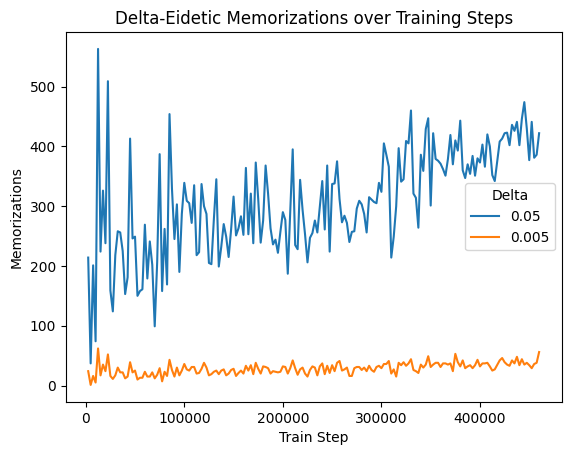

In [198]:
for i, delta in enumerate(deltas):
    plt.plot(ckpts, delta_mems[delta], label=delta)
plt.legend(title="Delta")
plt.title("Delta-Eidetic Memorizations over Training Steps")
plt.xlabel("Train Step")
plt.ylabel("Memorizations")
plt.show()

In [64]:
distances_avg = [
    torch.load(f'./trained_models/distances_sd_dup_avg_{i}.pt', map_location='cpu') for i in range(1, 10)
]
distances_nearest = [
    torch.load(f'./trained_models/distances_sd_dup_nearest_{i}.pt', map_location='cpu') for i in range(1, 10)
]
mems = [
    torch.load(f'./trained_models/distances_sd_dup_mem_{i}.pt', map_location='cpu') for i in range(1, 10)
]

In [65]:
deltas = [0.1, 0.05, 0.005]
avgs_deltas = {
    delta : [
        torch.sum(v < delta) for v in distances_avg
    ] for delta in deltas
}
nrst_deltas = {
    delta : [
        torch.sum(v < delta) for v in distances_nearest
    ] for delta in deltas
}

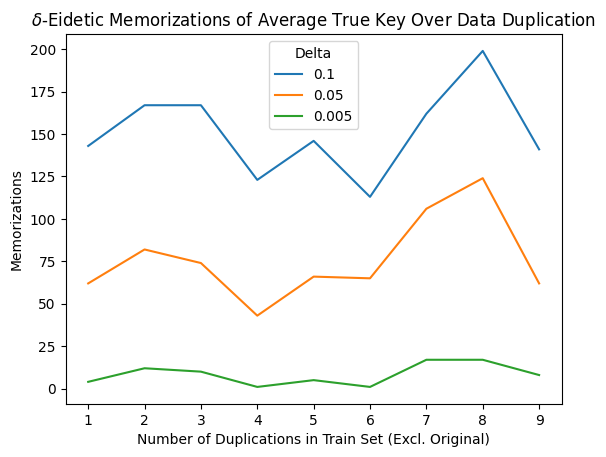

In [66]:
for i, delta in enumerate(deltas):
    plt.plot(range(1, 10), avgs_deltas[delta], label=delta)
plt.legend(title="Delta")
plt.title("$\delta$-Eidetic Memorizations of Average True Key Over Data Duplication")
plt.xlabel("Number of Duplications in Train Set (Excl. Original)")
plt.ylabel("Memorizations")
plt.show()

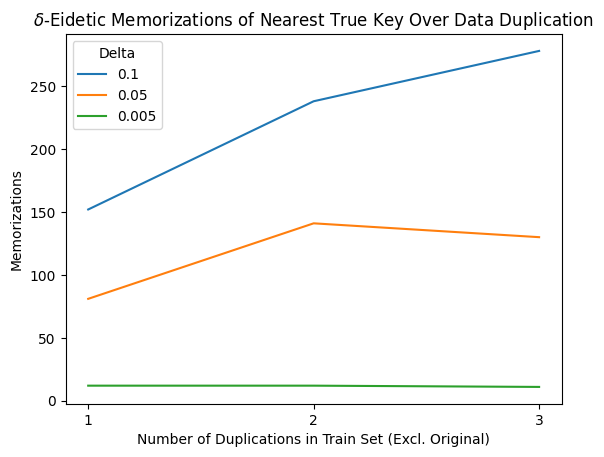

In [67]:
for i, delta in enumerate(deltas):
    plt.plot(range(1, 4), nrst_deltas[delta][:3], label=delta)
plt.legend(title="Delta")
plt.title("$\delta$-Eidetic Memorizations of Nearest True Key Over Data Duplication")
plt.xlabel("Number of Duplications in Train Set (Excl. Original)")
plt.ylabel("Memorizations")
plt.xticks(range(1, 4))
plt.show()

In [68]:
for delta in deltas:
    print(nrst_deltas[delta][:3])

[tensor(152), tensor(238), tensor(278)]
[tensor(81), tensor(141), tensor(130)]
[tensor(12), tensor(12), tensor(11)]


In [37]:
print(mems[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
mems_per_delta = {delta: [] for delta in deltas}
for delta in deltas:
    for i in range(len(mems)):
        mems_per_delta[delta].append([mems[i][j].item() if distances_nearest[i][j] < delta else -1 for j in range(mems[i].size(0))])

In [39]:
mems_per_delta = {
    k : [[lst[x:x+10] for x in range(0, len(lst), 10)] for lst in v] for k, v in mems_per_delta.items()
}

In [40]:
uniques_per_delta = {
    k : [[len(set(keys)) - 1 for keys in dup] for dup in v] for k, v in mems_per_delta.items()
}

In [41]:
print(mems_per_delta)

{0.1: [[[-1, -1, -1, 0, -1, -1, 0, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [0, 1, 1, 1, 1, 1, 0, 1, 1, 0], [-1, -1, -1, -1, -1, 1, -1, -1, -1, -1], [1, -1, -1, 0, -1, 1, 1, 1, -1, 1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [1, -1, 1, 1, 0, 1, -1, 1, 1, 1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [0, 1, 0, -1, 1, -1, 0, 0, -1, 0], [-1, -1, 1, -1, 1, -1, -1, -1, 1, 1], [-1, -1, -1, -1, -1, 1, -1, -1, -1, -1], [-1, -1, 1, 1, 1, 1, -1, 1, -1, -1], [1, -1, -1, -1, -1, 1, 1, -1, -1, -1], [-1, -1, 0, 0, -1, -1, -1, -1, 0, -1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, -1, 0, 1, -1, 1, -1, 1, 0], [1, -1, -1, -1, 1, -1, -1, -1, 1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, 1, -1, -1, -1, -1, -1, 0, 1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, 0], [0, -1, 0, -1, 0, -1, -1, -1, -1, 0], [1, -1, -1, -1, 1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 1, 

In [42]:
print(uniques_per_delta)

{0.1: [[1, 0, 1, 1, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0], [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1], [0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 3, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1], [2, 0, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 3, 2, 1, 1, 0, 2, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 2], [0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 4, 0, 3, 2, 2, 5, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 4, 0, 0, 1, 5, 2, 0, 0, 0, 0, 1], [2, 0, 0, 0, 2, 1, 2, 3, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1, 2, 3, 1, 0, 1, 1, 0, 0, 0, 3, 0, 0, 1,

In [43]:
freqs_per_delta = {
    k : [dict(Counter(uniques)) for uniques in v] for k, v in uniques_per_delta.items()
}

In [44]:
print(freqs_per_delta[0.05])

[{0: 26, 2: 6, 1: 14}, {0: 22, 1: 19, 2: 7, 3: 1}, {0: 19, 2: 6, 1: 21}, {1: 17, 0: 24, 2: 7}, {2: 11, 1: 18, 3: 1, 0: 19}, {0: 26, 1: 12, 3: 2, 2: 5, 5: 3}, {1: 20, 0: 15, 3: 2, 2: 12}, {0: 20, 3: 2, 1: 17, 2: 5, 4: 3}, {4: 6, 0: 13, 1: 19, 3: 3, 2: 7, 5: 1}]
